In [26]:
import os

import numpy as np
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

from utils import load_hidden_representations_from_hdf5, read_templates_from_file

----

In [27]:
# params
log_dir = "/logfiles"
model = "bigscience-T0_3B" # bigscience-T0_B or bigscience-T0
module = "decoder" # encoder or decoder
task = "rte"

## Prompts

In [28]:
df = read_templates_from_file(f"/t0-analysis/prompts/{task}.csv")
display(df)

,name,template,category,shuffle
0,null_pattern,{premise} {hypothesis},neutral,False
1,null_pattern_reversed,{hypothesis} {premise},neutral,False
2,gpt_3_yes_no,{premise} Question: {hypothesis} Yes or No?,instructive,False
3,gpt_3_yes_no_shuffled,{premise} Question: {hypothesis} Yes or No?,instructive,True
4,gpt_3_true_false,{premise} Question: {hypothesis} True or False?,instructive,False
5,gpt_3_true_false_shuffled,{premise} Question: {hypothesis} True or False?,instructive,True
6,start_with_the,"{premise} Does the paragraph start with ""the""?...",misleading,False
7,mnli_crowdsource,{premise} Using only the above description and...,instructive,False
8,based_on_previous_passage,{premise} Based on the previous passage; is it...,instructive,False
9,infer,"Suppose {premise} Can we infer that ""{hypothes...",instructive,False


## Plot t-SNE embeddings

In [29]:
# specify which patterns to use for classification
use_pattern = [
    # "null_pattern",
    # "null_pattern_reversed",
    "gpt_3_yes_no",
    # "gpt_3_yes_no_shuffled",
    "gpt_3_true_false",
    # "gpt_3_true_false_shuffled",
    # "start_with_the",
    "mnli_crowdsource",
    "based_on_previous_passage",
    "infer",
    "follow",
    "imply",
    "guaranteed",
    "justified", 
    "must_be_true",
    "should_assume"
]

Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5069.32it/s]


(3047, 2048)


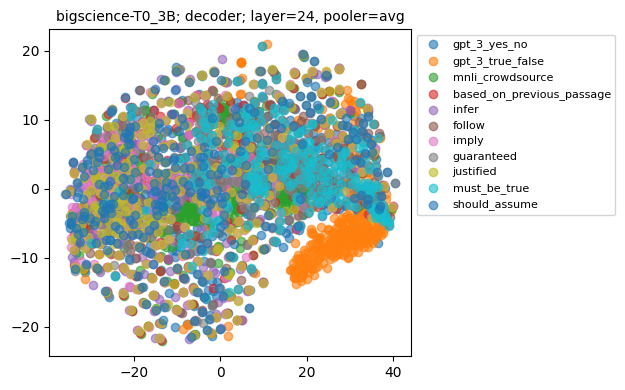

In [30]:
# for layer in range(0, 1):
# for layer in range(0, 5):
# for layer in range(0, 25):
for layer in range(24, 25):
    
    file_names, prompt_names = [], []

    for _, row in df.iterrows():
        if row['name'] in use_pattern:
            file_names.append(f"rte/{model}/{module}/{row['name']}/hidden_represenations_layer{layer}_avg.hdf5",)
            prompt_names.append(row['name'])
    
    # load hidden representations from hdf5 file
    representations = None
    n_sequences = 0

    for file_name in file_names:
        hidden_representations = load_hidden_representations_from_hdf5(os.path.join(log_dir, file_name))
        n_sequences = hidden_representations.shape[0]

        if representations is None:
            representations = hidden_representations
        else:
            representations = np.concatenate((representations, hidden_representations), axis=0)

    print(representations.shape)

    # compute t-SNE embeddings
    X = TSNE(
        n_components=2, 
        perplexity=200, 
        init='pca', # random or pca
        learning_rate=500,
        n_iter=1000
    ).fit_transform(representations)

    # plot t-SNE embeddings
    fig, axes = plt.subplots(1, 1, figsize=(5.5,4), dpi=100)

    for idx, file_name in enumerate(file_names):
        axes.scatter(X[n_sequences*idx:n_sequences*(idx + 1), 0], X[n_sequences*idx:n_sequences*(idx + 1), 1], alpha=0.6, label=prompt_names[idx])

    axes.set_title(f"{model}; {module}; layer={layer}, pooler=avg", fontsize=10)

   # Shrink current axis by 20%
    box = axes.get_position()
    axes.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    axes.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), fancybox=True, shadow=False, fontsize=8)

    plt.tight_layout()

    plt.show()
    plt.close();